# Creazione modelli per previsione SQUAT
> Decision TreeClassifier

> Logistic Regression 

> Regressione lineare multivariata

In [736]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns
import os

In [737]:
max_lunghezza_albero = 3
potatura = 0.01

shift = 0
rolling_periods = 5

## Import dati

In [738]:
# df_raw = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1205_1.csv' , sep=';' , decimal='.')
# df_raw.set_index('Time', inplace=True)
# df_raw.drop(columns='prob', inplace=True)
# df

In [739]:
# df1 = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1130_1.csv' , sep=';' , decimal='.')
# df2 = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1130_prob.csv' , sep=';' , decimal='.')
# df3 = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1130_watch.csv' , sep=';' , decimal='.')
df4 = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1205_1.csv' , sep=';' , decimal='.')
df5 = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_1205_2.csv' , sep=';' , decimal='.')
df_raw = pd.concat([
                    # df2,
                    # df3,
                    df4,
                    df5,
                    ], axis=0, ignore_index=True).drop(columns=[
                        'prob',
                        'Time',
                        # 'Mag',
                        ])
df_raw.reset_index(drop=True, inplace=True)
bar_zero = df_raw['BAR'][0]
df_raw['BAR'] = (df_raw['BAR']/bar_zero-1)*100
# df_raw.set_index('Time', inplace=True)
df_raw

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,UP,DOWN
0,9.40285,3.50631,0.66582,0.42,2.31,0.77,0.000000,0,0,0,0
1,9.66151,3.35542,0.85502,0.91,1.89,1.82,-0.001722,0,0,0,0
2,9.64474,3.44404,0.64666,1.54,1.75,-0.98,0.000147,0,0,0,0
3,9.49625,3.33626,0.91729,-0.28,1.82,-0.49,-0.000345,0,0,0,0
4,9.55373,3.47278,0.86460,-0.35,-0.35,0.42,-0.000222,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1336,0.63708,6.69887,7.36469,1.47,1.19,3.64,0.007357,0,0,0,1
1337,0.97956,6.64857,7.01262,4.69,0.07,7.14,0.006791,0,0,0,1
1338,0.73527,6.87131,6.89526,0.28,1.26,-2.73,0.008022,0,0,0,1
1339,0.75922,6.90724,7.08686,5.04,0.98,5.32,0.008194,0,0,0,1


In [740]:
df = df_raw.copy()

df_temp = df.loc[df['DOWN'] ==1]
pos = np.array(df_temp.index)
for i in pos:
    for k in range(-shift+1, shift, 1):
        df.at[i+k, 'DOWN'] =1

# df = df[df.columns.difference(['prob'])].rolling(3).mean()
df['Ax'] = df['Ax'].rolling(rolling_periods).mean()
df['Ay'] = df['Ay'].rolling(rolling_periods).mean()
df['Az'] = df['Az'].rolling(rolling_periods).mean()
df['BAR'] = df['BAR'].rolling(rolling_periods).mean()
df['Gx'] = df['Gx'].rolling(rolling_periods).mean()
df['Gy'] = df['Gy'].rolling(rolling_periods).mean()
df['Gz'] = df['Gz'].rolling(rolling_periods).mean()

df.dropna(inplace=True)

In [741]:
df

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,UP,DOWN
4,9.551816,3.422962,0.789878,0.448,1.484,0.308,-0.000428,0,0,0,0
5,9.593010,3.407154,0.833946,0.280,1.260,0.070,0.000418,0,0,0,0
6,9.570496,3.426314,0.844484,0.308,0.658,-0.308,0.001703,0,0,0,0
7,9.542236,3.425834,0.890946,0.126,0.392,-0.280,0.002367,0,0,0,0
8,9.553254,3.444036,0.880888,-0.084,-0.476,0.182,0.003459,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1336,0.822450,6.619832,7.236314,-0.560,-0.322,-0.378,0.007382,0,0,0,1
1337,0.816222,6.615042,7.213322,0.658,-0.070,0.840,0.007318,0,0,0,1
1338,0.831550,6.654800,7.125664,1.246,0.546,1.050,0.007657,0,0,0,1
1339,0.780776,6.742938,7.138118,2.128,1.064,1.442,0.007687,0,0,0,1


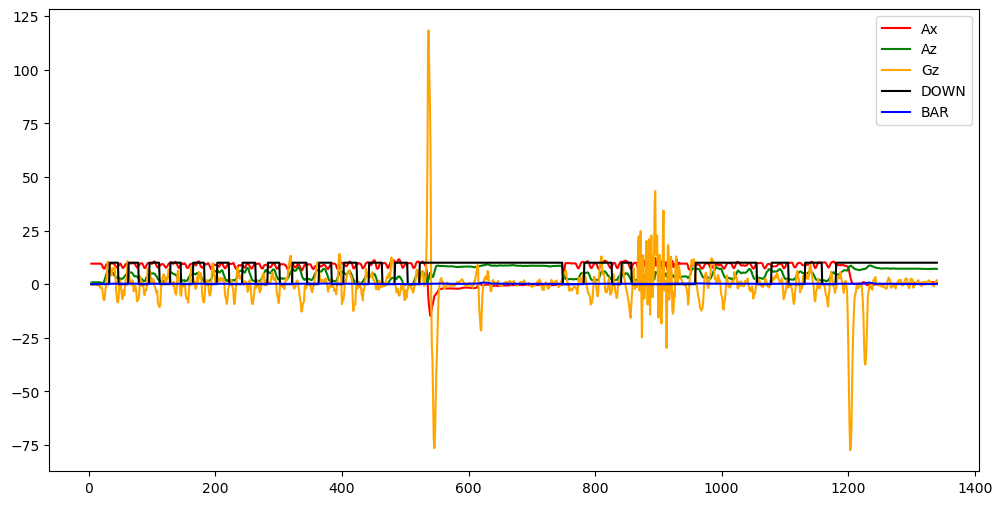

In [742]:
plt.figure(figsize=(12,6))
plt.plot(df['Ax'], color='red', label='Ax')
# plt.plot(df['Ay'], color='blue', label='Ay')
plt.plot(df['Az'], color='green', label='Az')
plt.plot(df['Gz'], color='orange', label='Gz')
plt.plot(df['DOWN']*10, color='black', label='DOWN')
plt.plot(df['BAR']*10, color='blue', label='BAR')
plt.legend()
plt.show()

## Preparazione datasets

In [743]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','UP'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.25, random_state=None)

# Modelli

## DecisionTree Classifier

Accuracy:   0.863
Precision:  0.865
Recall:     0.886


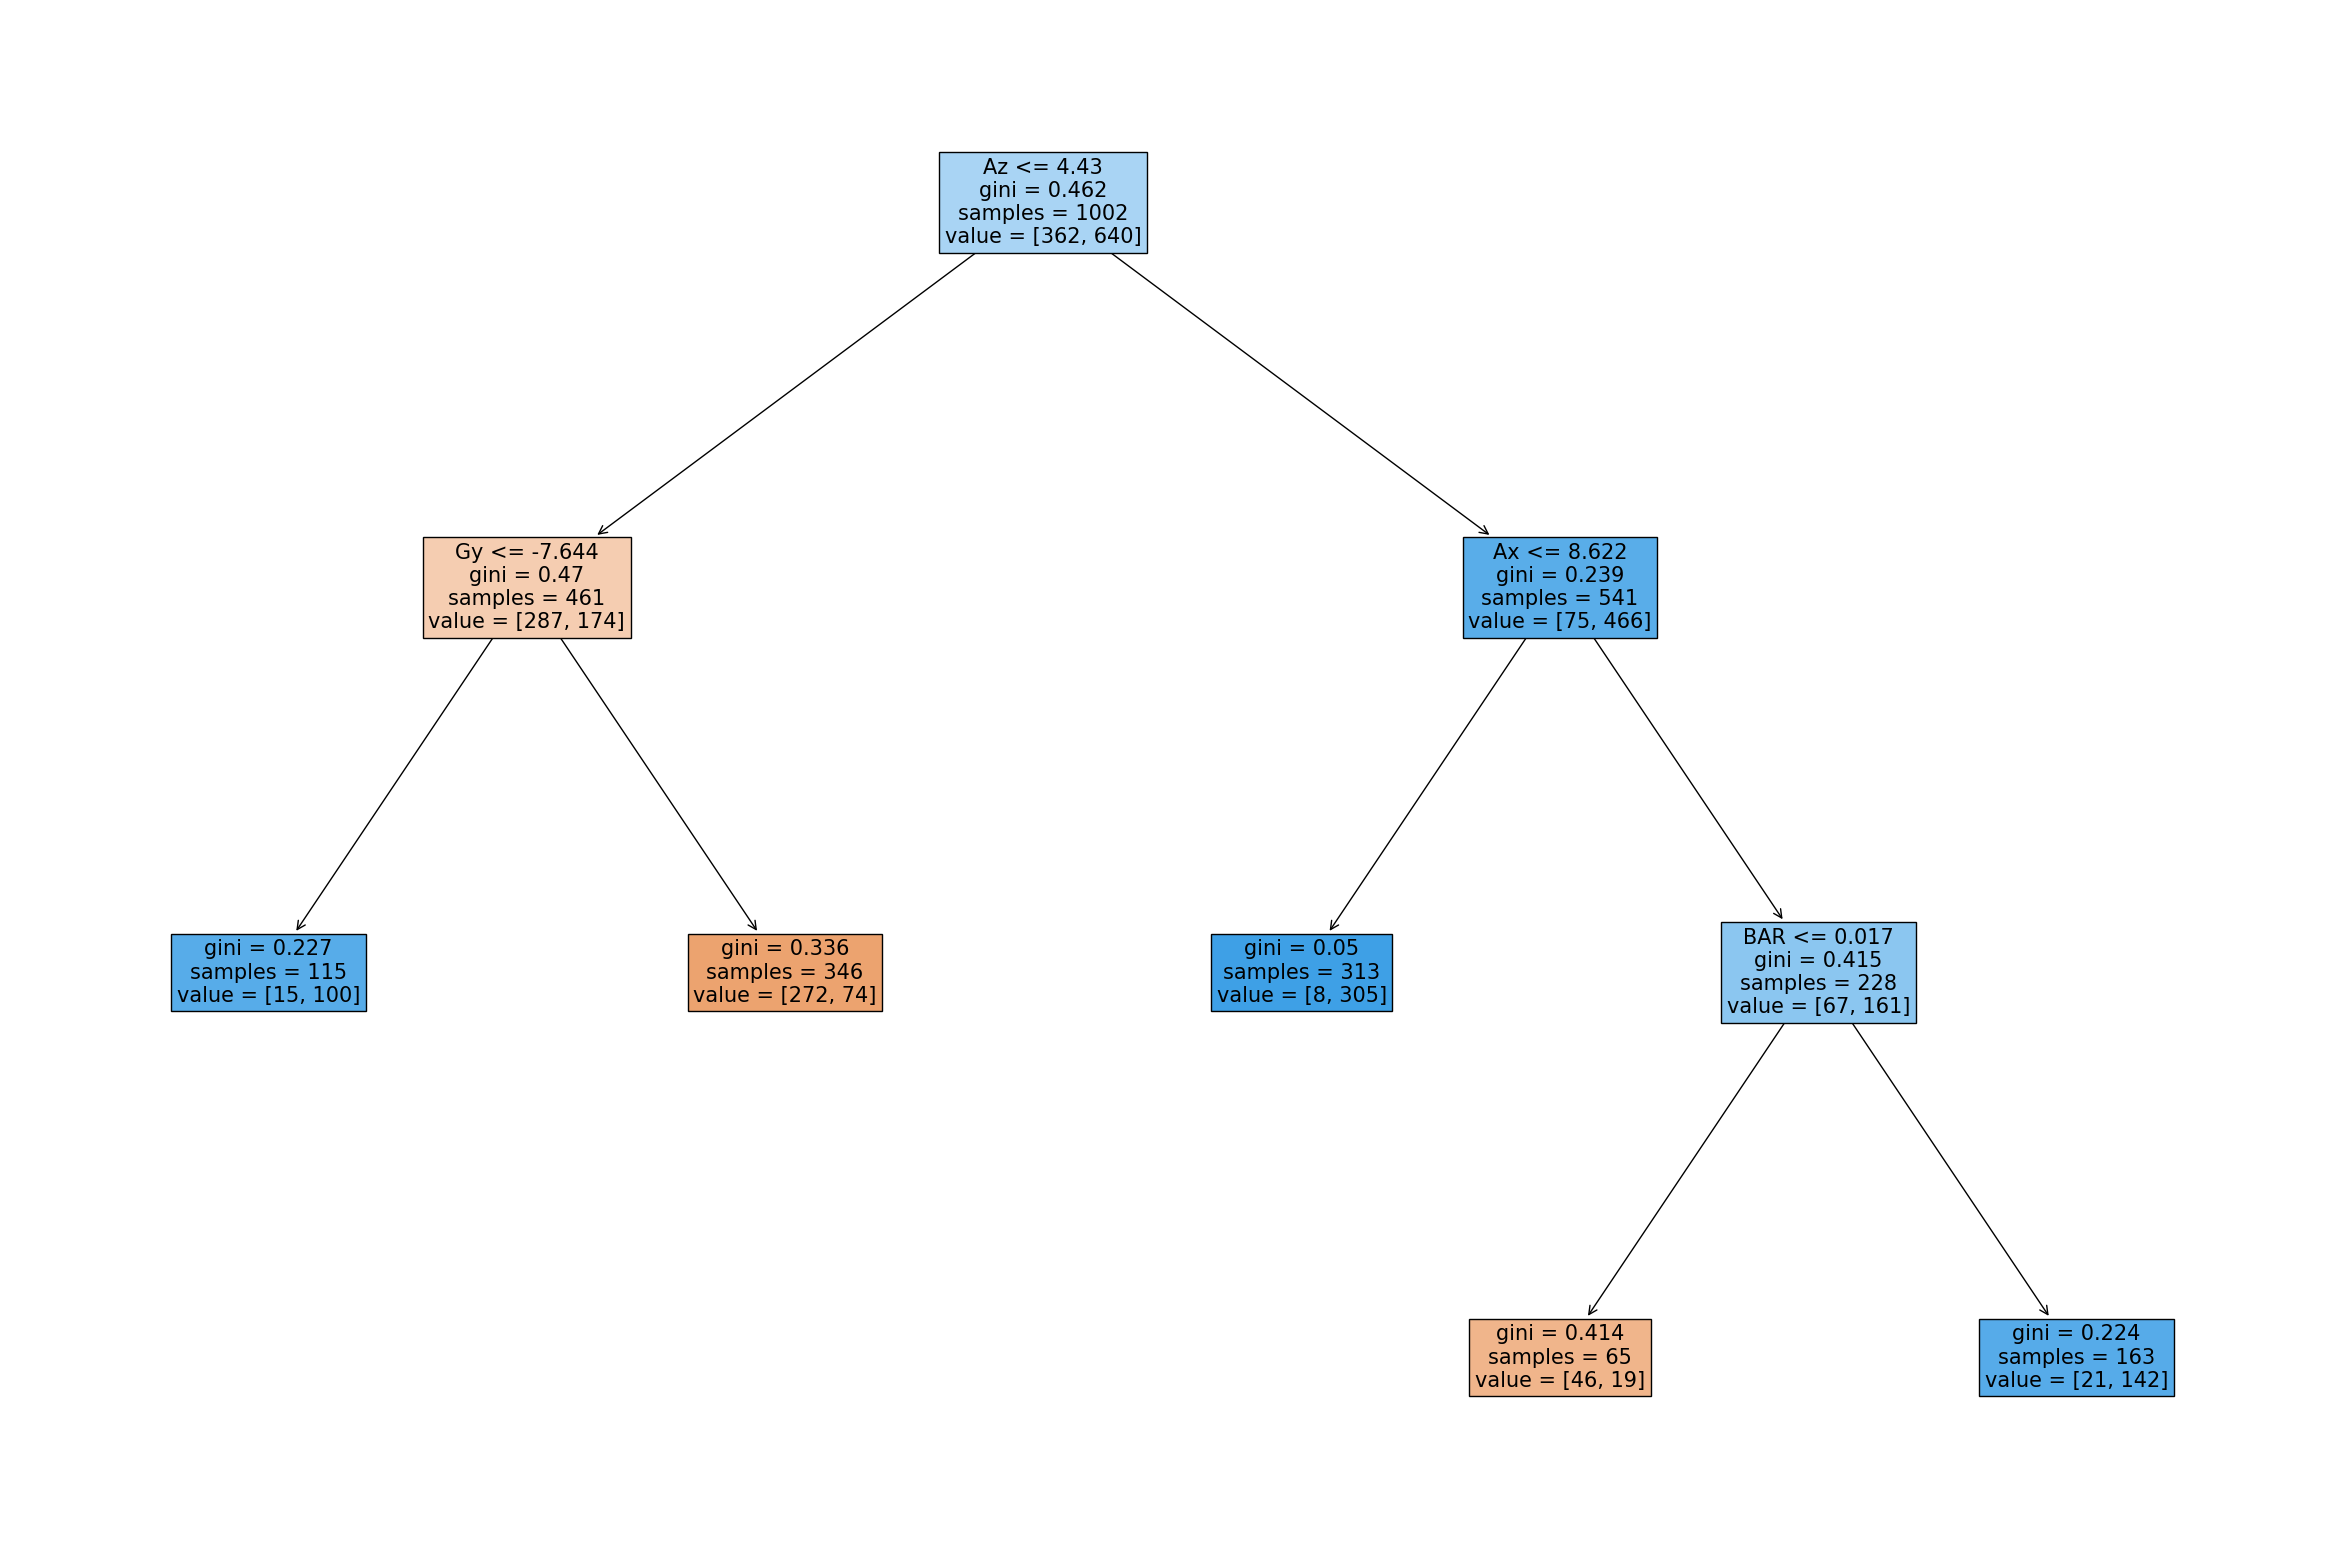

In [744]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=max_lunghezza_albero , ccp_alpha=potatura)
clf = clf.fit(X_train, y_train)
param = clf.get_params()
predictions = clf.predict(X_test)
accuracy = clf.score(X_train, y_train)
precision = precision_score(y_true= y_test, y_pred=predictions)
recall = recall_score(y_true= y_test, y_pred=predictions)

print('Accuracy:  ', round(accuracy,3))
print('Precision: ', round(precision,3))
print('Recall:    ', round(recall,3))

from sklearn import tree
feature_names = X.columns
fig = plt.figure(figsize=(30,20))
_= tree.plot_tree(clf, 
        feature_names=feature_names, 
        filled=True, fontsize=15)


In [745]:
##importanza features
feature_names = X.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index=feature_names).sort_values(0, ascending=False)

print(feature_importance.head(10))
important_features = list(feature_importance[feature_importance[0]>0].index)
# feature_importance.head(10).plot(kind='bar')

            0
Az   0.483874
Gy   0.308045
BAR  0.129256
Ax   0.078825
Ay   0.000000
Gx   0.000000
Gz   0.000000
P    0.000000
R    0.000000


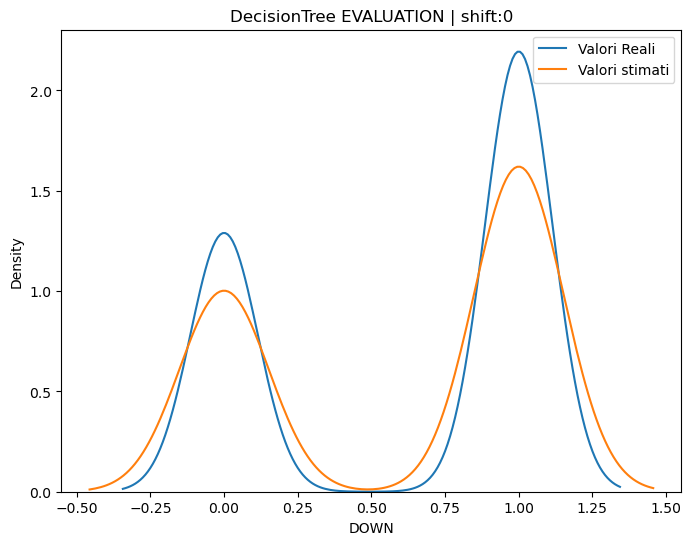

In [746]:
plt.figure(figsize=(8, 6))
plt.title('DecisionTree EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(predictions , label='Valori stimati')
plt.legend()
plt.show()

## Logistic Regression

In [747]:
log_reg = LogisticRegression(random_state=None, solver = 'lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

lr = pd.DataFrame(data =[X_train.columns, np.array(log_reg.coef_[0]).tolist()]).T
lr.rename(columns={0:'Reg',1:'Logistic'}, inplace=True)
lr.set_index('Reg', inplace=True)
lr.sort_values(by='Logistic', key=abs, ascending=False , inplace=True)
print(lr)
print('Termine noto:',log_reg.intercept_[0])

     Logistic
Reg          
Ax  -0.655057
Az   0.455257
BAR  0.232813
Ay  -0.231097
Gy  -0.074625
Gz   0.025932
Gx  -0.023721
P         0.0
R         0.0
Termine noto: 4.8441171455804035


LogReg Training Accuracy is:  0.8343313373253493
LogReg Testing Accuracy is:  0.8029850746268656


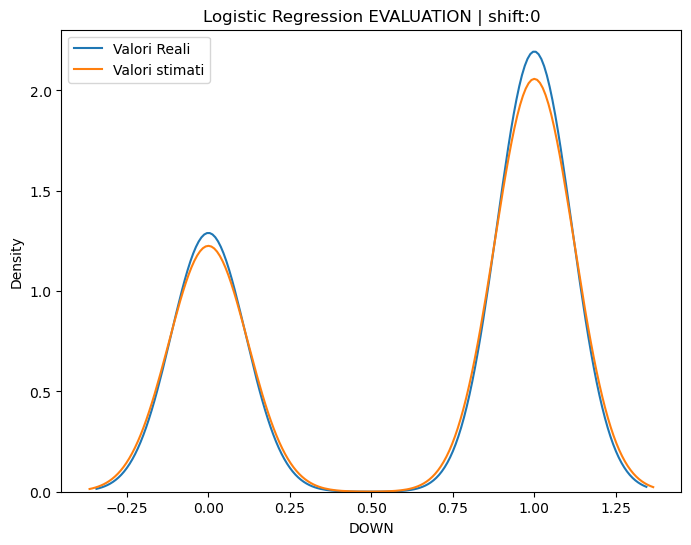

In [748]:
'''Logistic Regression EVALUATION'''

# Accuracy on Train
print("LogReg Training Accuracy is: ", log_reg.score(X_train, y_train))
# Accuracy on Test
print("LogReg Testing Accuracy is: ", log_reg.score(X_test, y_test))
# Classification Report

plt.figure(figsize=(8, 6))
plt.title('Logistic Regression EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(y_pred , label='Valori stimati')
plt.legend()
plt.show()


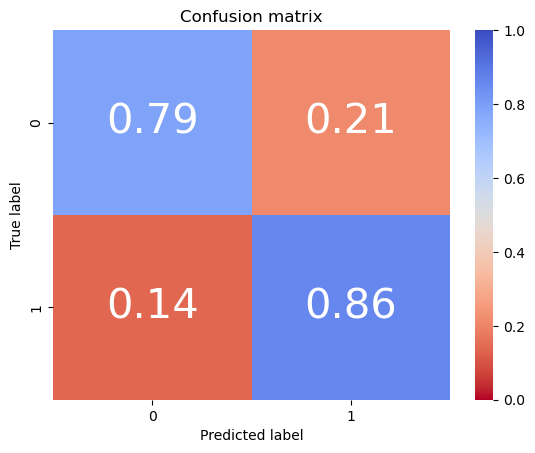

In [749]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="coolwarm_r", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    vmin=0., vmax=1., 
                    annot=True, annot_kws={'size':30}
                    )
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [750]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)

The True Positive Rate is: [0.78729282 0.8609375 ]
The Precision is: [0.76203209 0.87738854]
The False positive rate is: [0.1390625  0.21270718]
The False Negative Rate is:  [0.21270718 0.1390625 ]


## Regressione Lineare Multivariata

          RLM
Reg          
BAR  3.383096
Az   0.061614
Ay  -0.042647
Ax  -0.039931
Gy  -0.008633
Gz   0.004393
Gx  -0.003788
P         0.0
R         0.0
Termine noto: 0.6609640047946275
 
Precisione:  0.3702090118283472


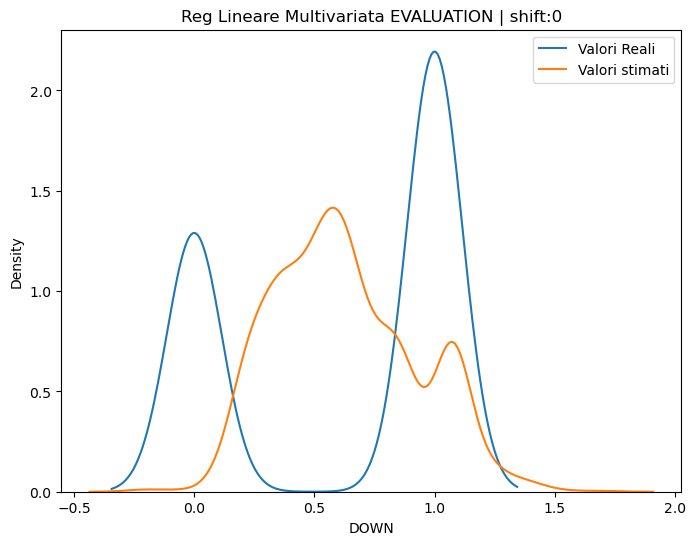

In [751]:
mlr = LinearRegression()
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','UP'], axis=1, inplace=True)

mlr.fit(X, y)
Y_hat = mlr.predict(X)
b0 = mlr.coef_
b1 = mlr.intercept_

reg = pd.DataFrame(data =[X.columns, b0]).T
reg.rename(columns={0:'Reg',1:'RLM'}, inplace=True)
reg.set_index('Reg', inplace=True)
reg.sort_values(by='RLM', key=abs, ascending=False , inplace=True)

print(reg)
print('Termine noto:',b1)
print(' ')
print('Precisione: ', mlr.score(X, y))

plt.figure(figsize=(8, 6))
plt.title('Reg Lineare Multivariata EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(Y_hat , label='Valori stimati')
plt.legend()
plt.show()
